In [35]:
# Import libraries and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as pltticker
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import itertools as itt
import pickle as pk
import dataframe_image as dfi

with open('../data/cleaned/baseline_regression_y_pred.pickle', 'rb') as f:
    baseline_y_pred = pk.load(f)

with open('../data/cleaned/log_continuous_y_pred_on_test.pickle', 'rb') as f:
    log_cont_y_pred = pk.load(f)

with open('../data/cleaned/log_continuous_with_interactions_y_pred_on_test.pickle', 'rb') as f:
    log_cont_interactions_y_pred = pk.load(f)
    
with open('../data/cleaned/baseline_regression_coeff_frame.pickle', 'rb') as f:
    baseline_df = pk.load(f)
    
with open('../data/cleaned/log_continuous_coeff_frame.pickle', 'rb') as f:
    log_cont_df = pk.load(f)
    
with open('../data/cleaned/log_continuous_with_interactions_coeff_frame.pickle', 'rb') as f:
    log_cont_interactions_df = pk.load(f)

    
all_data = pd.read_parquet('../data/cleaned/cleaned_data.parquet')
full_test = pd.read_parquet('../data/cleaned/all_features_test.parquet')
y_test_norm, y_test_log, X_test = [full_test.price, full_test['log(price_plus_0)'],
                                   full_test.drop(['price', 'log(price_plus_0)'], axis = 1)]

In [36]:
def calculate_coeff_value_by_type(row, y_type):
    if y_type == 'normal':
        if row.Type == 'Normal':
            return row.Coefficient
        else:
            return row.Coefficient * np.log(1.01)
    else:
        if row.Type == 'Normal':
            return np.exp(row.Coefficient)
        else:
            return 1.01 ** row.Coefficient

In [37]:
baseline_df = baseline_df.round(2)
baseline_df['coeff_abs'] = baseline_df.coeff.abs()
best_baseline_df_zipcodes = baseline_df.loc[(baseline_df.p_values < 0.05)
                                            & (baseline_df.param != 'const')]\
                                            .nlargest(3, 'coeff_abs').param.values.tolist()
select_params = ['waterfront', 'grade', 'sqft_living', 'sqft_lot']
params_to_show = select_params + best_baseline_df_zipcodes

In [38]:
baseline_to_show = baseline_df.loc[baseline_df.param.isin(params_to_show)][['param', 'coeff']]
baseline_to_show.columns = ['Feature', 'Coefficient']

pd.options.display.float_format = '{:,.2f}'.format

baseline_to_show.Feature = ['Waterfront', 'Grade', 'Sqft Living',
                            'Sqft Lot', 'Zip - 98004', 'Zip - 98039', 'Zip - 98040']
baseline_to_show = baseline_to_show.groupby('Feature').first()
baseline_to_show['Type'] = 'Normal'

baseline_to_show['Coefficient Effect'] = baseline_to_show.apply(lambda x: calculate_coeff_value_by_type(x, 'normal'),
                                                                axis = 1)
# Save image
dfi.export(baseline_to_show, '../images/baseline_coeff.png')

In [39]:
log_cont_df = log_cont_df.round(2)
log_cont_df['coeff_abs'] = log_cont_df.coeff.abs()
best_log_cont_df_zipcodes = log_cont_df.loc[(log_cont_df.p_values < 0.05)
                                            & (log_cont_df.param != 'const')]\
                                            .nlargest(3, 'coeff_abs').param.values.tolist()
select_params = ['waterfront', 'grade', 'log(sqft_living_plus_0)', 'log(sqft_lot_plus_0)']
params_to_show = select_params + best_log_cont_df_zipcodes

In [40]:
log_cont_to_show = log_cont_df.loc[log_cont_df.param.isin(params_to_show)][['param', 'coeff']]
log_cont_to_show.columns = ['Feature', 'Coefficient']

pd.options.display.float_format = '{:,.2f}'.format

log_cont_to_show.Feature = ['Waterfront', 'Grade', 'Log Sqft Living',
                            'Log Sqft Lot', 'Zip - 98004', 'Zip - 98033', 'Zip - 98039']
log_cont_to_show = log_cont_to_show.groupby('Feature').first()
log_cont_to_show['Type'] = ['Normal', 'Log', 'Log', 'Normal', 'Normal', 'Normal', 'Normal']



log_cont_to_show['Coefficient Effect'] = log_cont_to_show.apply(lambda x: calculate_coeff_value_by_type(x, 'log'),
                                                                axis = 1)
# Save image
dfi.export(log_cont_to_show, '../images/long_cont_coeff.png')

In [41]:
grouped_by_zip = all_data.groupby('zipcode').mean()
top_5_zip_by_price = grouped_by_zip.price.nlargest(5).index.tolist()
least_5_zip_by_price = grouped_by_zip.price.nsmallest(5).index.tolist()
least_5_zip_by_price.reverse()
most_influential_zip_by_price = top_5_zip_by_price + least_5_zip_by_price

In [42]:
def configure_axislabels_and_title(ax, xlabel, ylabel, title):
    # Set fonts, padding, and fontsize for axis labels and title
    ax.set_xlabel(xlabel,
                  fontfamily = 'Arial',
                  fontsize = 24,
                  labelpad = 5)

    ax.set_ylabel(ylabel,
                  fontfamily = 'Arial',
                  fontsize = 24,
                  labelpad = 10)

    ax.set_title(title,
                 fontfamily = 'Arial',
                 fontsize = 32,
                 pad = 10)
    
    return None

In [43]:
def configure_ticklabels_and_params(ax):
    # Set label sizes and tick lengths
    ax.tick_params(axis = 'both',
                   which = 'major',
                   labelsize = 16,
                   length = 8,
                   width = 1)

    # Set font for tick labels on both axes
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")

    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
        
    return None

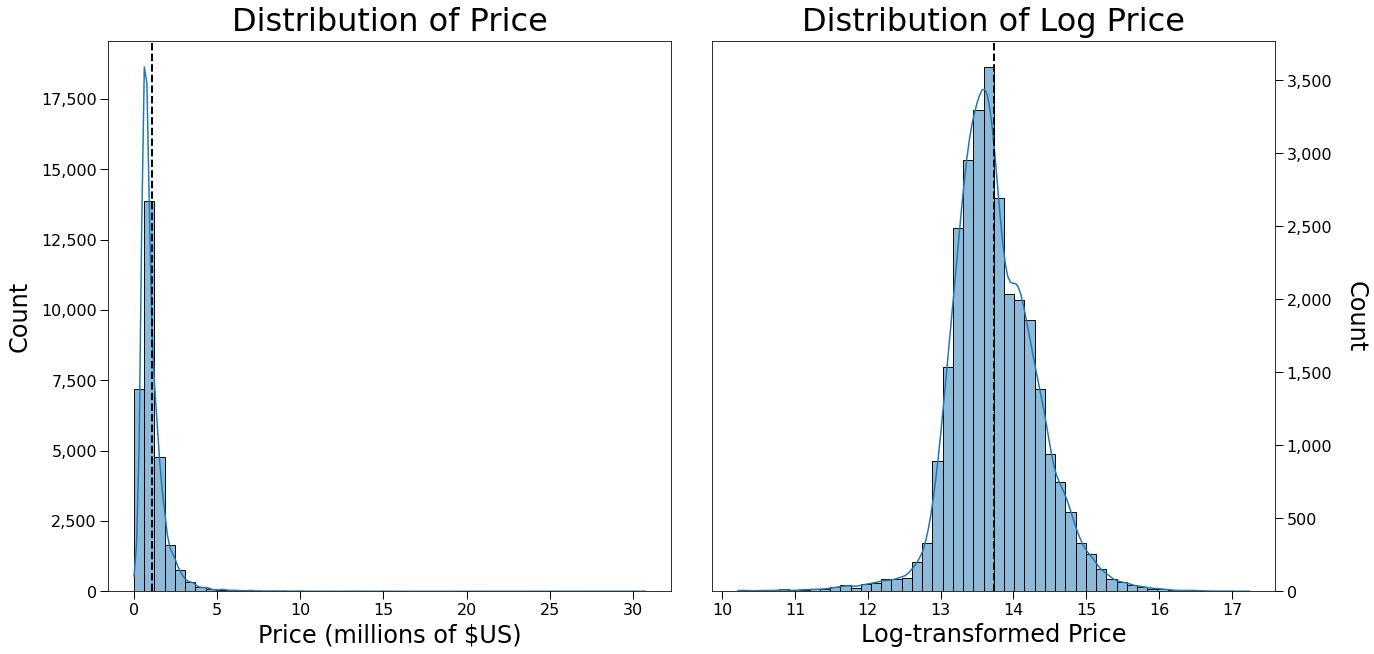

In [64]:
# Declare fig, ax objects
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

# Create seaborn histplots
sns.histplot(all_data.price, bins = 50, kde = True, ax = ax[0]);

sns.histplot(np.log(all_data.price), bins = 50, kde = True, ax = ax[1]);

# Create vertical lines for each ax object representing mean price/mean log price respectively
ax[0].axvline(x = all_data.price.mean(), linestyle = '--', linewidth = 2, c = 'k')
ax[1].axvline(x = np.log(all_data.price).mean(), linestyle = '--', linewidth = 2, c = 'k')

# Configure tick labels and ticks
# Format ax[0] x-labels to print as millions of $US
ax[0].get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))

ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

for axis in ax:
    axis.get_yaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    configure_ticklabels_and_params(axis)
    
# Set axes labels and titles
configure_axislabels_and_title(ax[0],
                               'Price (millions of $US)',
                               'Count',
                               'Distribution of Price')

configure_axislabels_and_title(ax[1],
                               'Log-transformed Price',
                               'Count',
                               'Distribution of Log Price')

# Have to set ax_1 y_label separately to rotate
ax[1].set_ylabel('Count',
                 fontfamily = 'Arial',
                 fontsize = 24,
                 labelpad = 35,
                 rotation = 270)

# Set tight layout
plt.tight_layout(pad = 4.0)

# Save image
plt.savefig('../images/price_distributions.png')

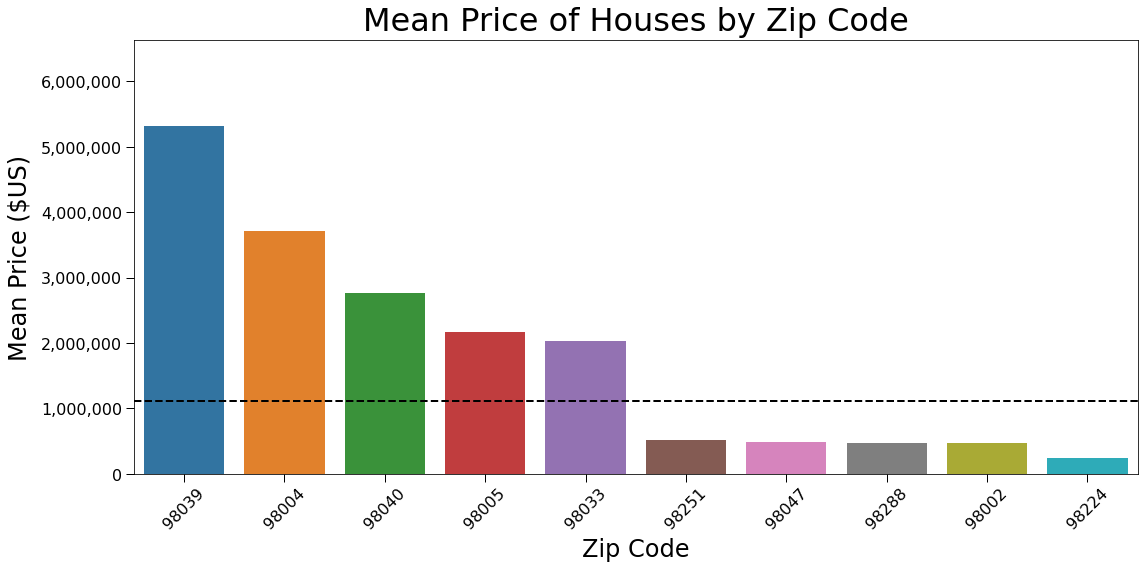

In [45]:
# Declare fig, ax objects
fig, ax = plt.subplots(figsize = (16, 8))

# Create seaborn barplot
sns.barplot(x = all_data.loc[all_data.zipcode.isin(most_influential_zip_by_price)].zipcode,
            y = all_data.price,
            order = most_influential_zip_by_price,
            errwidth = 0,
            ax = ax);

# Create horizontal line depicting mean price of all houses
ax.axhline(y = all_data.price.mean(), linestyle = '--', linewidth = 2, c = 'k')

# Set axis labels and title
configure_axislabels_and_title(ax, 'Zip Code', 'Mean Price ($US)', 'Mean Price of Houses by Zip Code')

# Configure tick labels and ticks
ax.get_yaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.xticks(rotation = 45)

configure_ticklabels_and_params(ax)

# Set tight layout
plt.tight_layout()

# Save image
plt.savefig('../images/mean_price_by_zipcode.png')

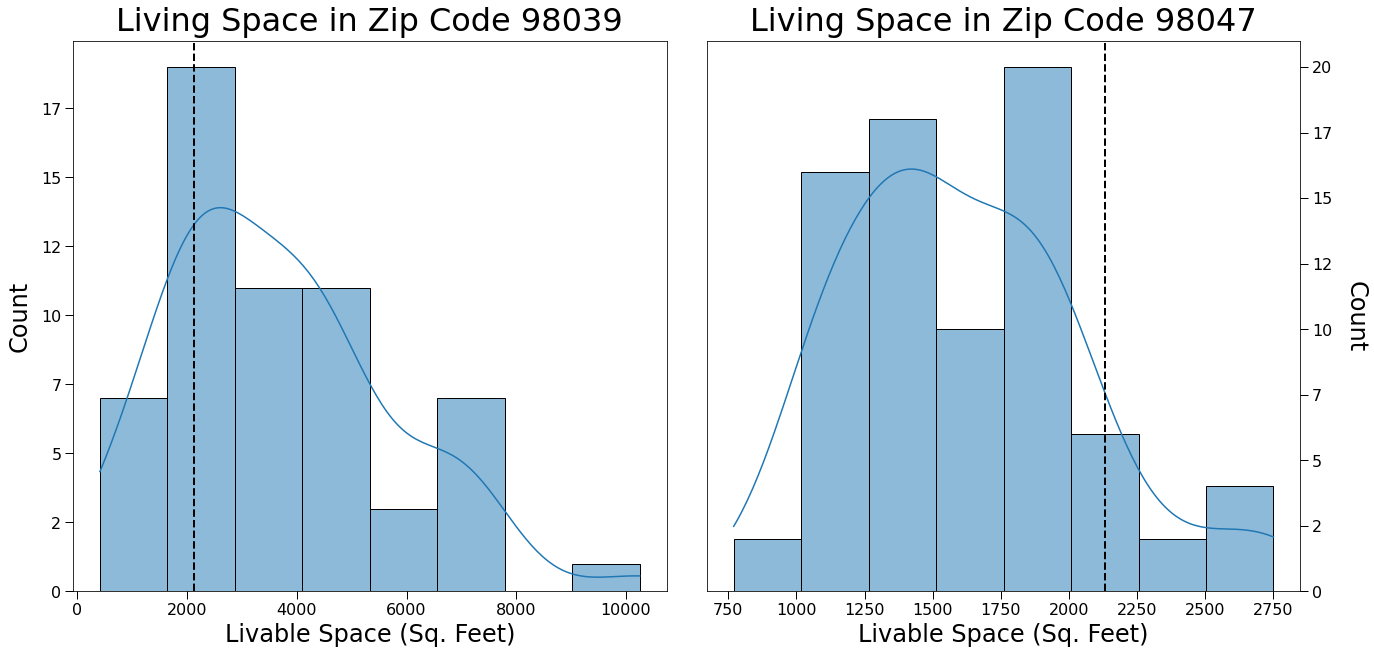

In [62]:
# Create fig, ax objects
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

# Create seaborn histplots
sns.histplot(all_data.loc[all_data.zipcode == most_influential_zip_by_price[0]].sqft_living,
             kde = True,
             ax = ax[0]);

sns.histplot(all_data.loc[all_data.zipcode == most_influential_zip_by_price[6]].sqft_living,
             kde = True,
             ax = ax[1]);

# Configure axes
for axis in ax:
    axis.axvline(x = all_data.sqft_living.mean(), linestyle = '--', linewidth = 2, c = 'k')
    axis.get_yaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    configure_ticklabels_and_params(axis)

ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

# Configure axis and title labels
configure_axislabels_and_title(ax[0],
                               'Livable Space (Sq. Feet)',
                               'Count',
                               'Living Space in Zip Code {}'\
                               .format(most_influential_zip_by_price[0]))

configure_axislabels_and_title(ax[1],
                               'Livable Space (Sq. Feet)',
                               'Count',
                               'Living Space in Zip Code {}'\
                               .format(most_influential_zip_by_price[6]))

# Have to set ax_1 y_label separately to rotate
ax[1].set_ylabel('Count',
                 fontfamily = 'Arial',
                 fontsize = 24,
                 labelpad = 35,
                 rotation = 270)

# Set tight layout
plt.tight_layout(pad = 4.0)

# Save image
plt.savefig('../images/sqft_living_by_zipcode.png')

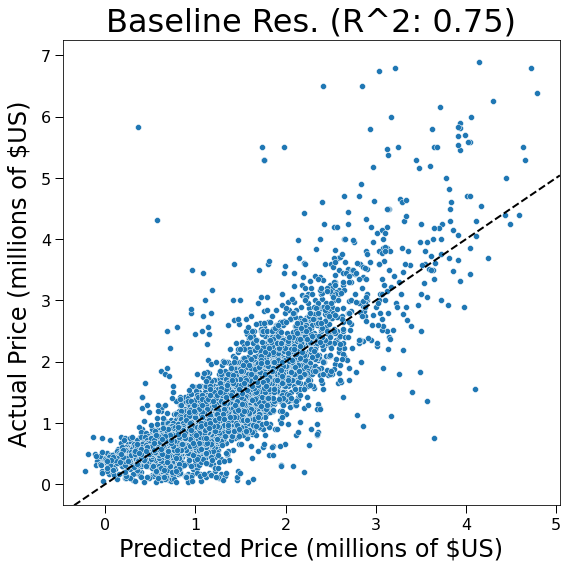

In [29]:
# Declare fig, ax objects
fig, ax = plt.subplots(figsize = (8, 8))

# Create seaborn scatterplot
sns.scatterplot(x = baseline_y_pred, y = y_test_norm);

# Draw line y = x to show where equality between prediction and actual should be
ax.axline([0, 0], [1, 1], linestyle = '--', linewidth = 2, c = 'k');

# Configure tick labels and ticks
ax.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))
ax.get_yaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))

configure_ticklabels_and_params(ax)

# Configure axis labels and title
configure_axislabels_and_title(ax,
                               'Predicted Price (millions of $US)',
                               'Actual Price (millions of $US)',
                               'Baseline Res. (R^2: 0.75)')

# Set tight layout
plt.tight_layout()

# Save image
plt.savefig('../images/baseline_residuals.png')

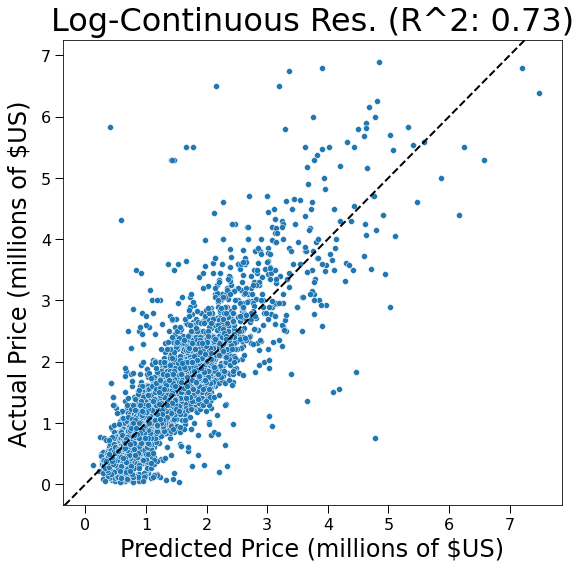

In [30]:
# Declare fig, ax objects
fig, ax = plt.subplots(figsize = (8, 8))

# Create seaborn scatterplot
sns.scatterplot(x = np.exp(log_cont_y_pred), y = np.exp(y_test_log));

# Draw line y = x to show where equality between prediction and actual should be
ax.axline([0, 0], [1, 1], linestyle = '--', linewidth = 2, c = 'k');

# Configure tick labels and ticks
ax.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))
ax.get_yaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))

configure_ticklabels_and_params(ax)

# Configure axis labels and title
configure_axislabels_and_title(ax,
                               'Predicted Price (millions of $US)',
                               'Actual Price (millions of $US)',
                               'Log-Continuous Res. (R^2: 0.73)')

# Set tight layout
plt.tight_layout()

# Save image
plt.savefig('../images/log_cont_residuals.png')

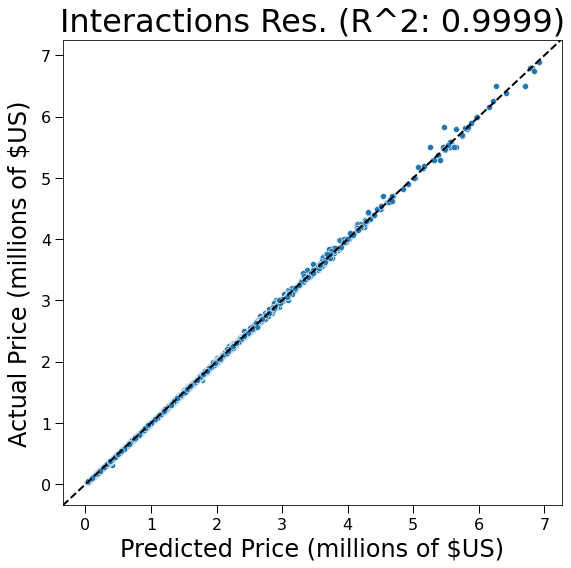

In [31]:
# Declare fig, ax objects
fig, ax = plt.subplots(figsize = (8, 8))

# Create seaborn scatterplot
sns.scatterplot(x = np.exp(log_cont_interactions_y_pred), y = np.exp(y_test_log));

# Draw line y = x to show where equality between prediction and actual should be
ax.axline([0, 0], [1, 1], linestyle = '--', linewidth = 2, c = 'k');

# Configure tick labels and ticks
ax.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))
ax.get_yaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))

configure_ticklabels_and_params(ax)

# Configure axis labels and title
configure_axislabels_and_title(ax,
                               'Predicted Price (millions of $US)',
                               'Actual Price (millions of $US)',
                               'Interactions Res. (R^2: 0.9999)')

# Set tight layout
plt.tight_layout()

# Save image
plt.savefig('../images/log_cont_with_interactions_residuals.png')